In [1]:
from PIL import Image
import numpy as np
import os
from pylab import *

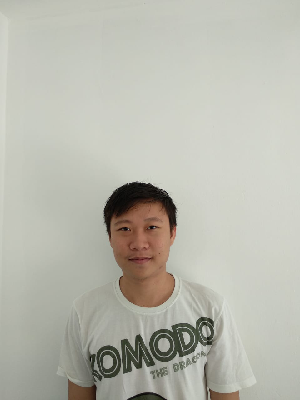

In [2]:
image = array(Image.open('agus2.jpeg').resize((300, 400)))
Image.fromarray(image)

In [3]:
image_new = image.copy()
for idx_row, row in enumerate(image):
    for idx_col, column in enumerate(row):
        image_new[idx_row][idx_col][0] = 0.299 * image[idx_row][idx_col][0] + 0.587 * image[idx_row][idx_col][1] + 0.114 * image[idx_row][idx_col][2]
        image_new[idx_row][idx_col][1] = 128 - 0.169 * image[idx_row][idx_col][0] - 0.331 * image[idx_row][idx_col][1] + 0.5 * image[idx_row][idx_col][2]
        image_new[idx_row][idx_col][2] = 128 + 0.5 * image[idx_row][idx_col][0] - 0.419 * image[idx_row][idx_col][1] - 0.081 * image[idx_row][idx_col][2]

In [4]:
# ( Y > 50)and (Y < 175) and
#  ( Cb > 90)and (Cb < 120) and ……….. (4)
#  ( Cr > 140)and (Cr < 165) and
#  ( Cr > 𝐶b)and (Cr − Cb > 15)
def isSkinColor(pixel):
    return pixel[0] > 80 and pixel[1] > 85 and pixel[1] < 135 and pixel[2] > 135 and pixel[2] < 180
#     return pixel[0] > 50 and pixel[0] < 175 and pixel[1] > 90 and pixel[1] < 120 and pixel[2] > 140 and pixel[2] < 165 and pixel[2] > pixel[1] and pixel[2] - pixel[1] > 15

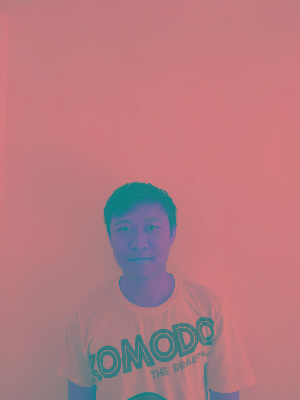

In [5]:
Image.fromarray(image_new)

In [6]:
image_face = image_new.copy()

In [7]:
for idx_row, row in enumerate(image_face):
    for idx_col, col in enumerate(row):
        if isSkinColor(col):
            image_face[idx_row][idx_col] = 255
        else:
            image_face[idx_row][idx_col] = 0

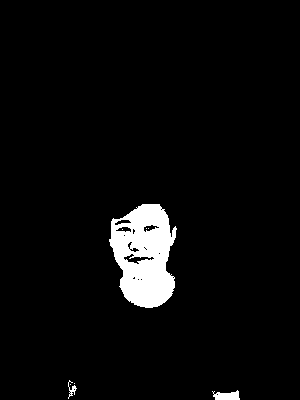

In [8]:
Image.fromarray(image_face)

In [9]:
def find_face(image_arr):
    min_row = inf
    min_col = inf
    max_row = 0
    max_col = 0
    found_white = False
    for idx_row, row in enumerate(image_face):
        all_black = True
        for idx_col, col in enumerate(row):
            if col[0] == 255: # white
                if idx_col > max_col:
                    max_col = idx_col
                if idx_col < min_col:
                    min_col = idx_col
                if idx_row > max_row:
                    max_row = idx_row
                if idx_row < min_row:
                    min_row = idx_row
                all_black = False
                found_white = True
            else:
                continue
        if all_black and found_white:
            break
    return min_col, min_row, max_col, max_row

In [10]:
min_col, min_row, max_col, max_row = find_face(image_face)

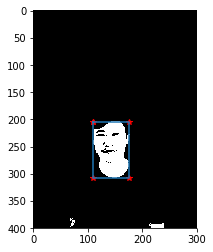

In [11]:
x = [min_col, max_col, max_col, min_col, min_col]
y = [min_row, min_row, max_row, max_row, min_row]

imshow(image_face)
plot(x, y, 'r*')
plot(x, y)
show()

In [12]:
image_face_new = Image.fromarray(image_face).crop((min_col, min_row, max_col, max_row)).convert('L').resize((75, 100))

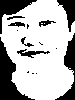

In [13]:
image_face_new

In [14]:
image_face_arr = array(image_face_new)

In [15]:
image_face_arr.shape

(100, 75)

In [16]:
# eyelash = []
# eye
# nose
# mouth
# jaw no hope la

In [17]:
def sum_region(left_top_corner, right_bottom_corner, image_arr):
    sum_result = 0
    left = left_top_corner[0]
    top = left_top_corner[1]
    right = right_bottom_corner[0]
    bottom = right_bottom_corner[1]
    for idx_row in range(top, bottom):
        for idx_col in range(left, right):
                if image_arr[idx_row][idx_col] == 0:
                    sum_result += 1
        
    return sum_result

In [18]:
image_face_arr.shape

(100, 75)

In [19]:
def find_mouth(image_face_arr):
    mouth_width = 30
    mouth_height = 12

    maks = 0
    found = False
    mouth_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(len(image_face_arr)):
        for idx_col in range(len(image_face_arr[0])):
            if idx_col + mouth_width >= image_face_arr.shape[1]: #OOB
                break

            white = sum_region((idx_col, idx_row), (idx_col + mouth_width, idx_row + mouth_height // 2), image_face_arr)
            black = sum_region((idx_col, idx_row + mouth_height // 2), (idx_col + mouth_width, idx_row + mouth_height), image_face_arr)
            if black - white >= maks:
                maks = black - white
                mouth_position[0][0] = idx_col
                mouth_position[0][1] = idx_row + mouth_height // 2
                mouth_position[1][0] = idx_col + mouth_width
                mouth_position[1][1] = idx_row + mouth_height
            
        if idx_row + mouth_height >= image_face_arr.shape[0]:
            break
    return mouth_position

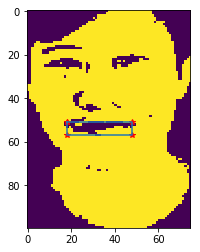

In [20]:
mouth_position = find_mouth(image_face_arr)
mouth_left_position = mouth_position[0][0]
mouth_top_position = mouth_position[0][1]
mouth_right_position = mouth_position[1][0]
mouth_bottom_position = mouth_position[1][1]

x = [mouth_left_position, mouth_right_position, mouth_right_position, mouth_left_position, mouth_left_position]
y = [mouth_top_position, mouth_top_position, mouth_bottom_position, mouth_bottom_position, mouth_top_position]

imshow(image_face_arr)
plot(x, y, 'r*')
plot(x, y)
show()

In [21]:
def find_nose(image_face_arr, mouth_top_position, mouth_left_position, mouth_right_position):
    nose_width = 18
    nose_height = 20

    maks = 0
    found = False
    nose_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(mouth_top_position - 22, mouth_top_position - nose_height):
        for idx_col in range(mouth_left_position, mouth_right_position - nose_width):
            if idx_col + nose_width >= image_face_arr.shape[1]: #OOB
                break

            black1 = sum_region((idx_col, idx_row), (idx_col + (nose_width // 3), idx_row + nose_height), image_face_arr)
            white = sum_region((idx_col + (nose_width // 3), idx_row), (idx_col + ((nose_width * 2) // 3), idx_row + nose_height), image_face_arr)
            black2 = sum_region((idx_col + ((nose_width * 2) // 3), idx_row), (idx_col + nose_width, idx_row + nose_height), image_face_arr)
            if (black1 + black2) - white >= maks:
                maks = black1 + black2 - white
                nose_position[0][0] = idx_col
                nose_position[0][1] = idx_row
                nose_position[1][0] = idx_col + nose_width
                nose_position[1][1] = idx_row + nose_height
        if idx_row + nose_height >= image_face_arr.shape[0]:
            break
    return nose_position

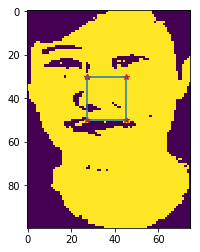

In [22]:
nose_position = find_nose(image_face_arr, mouth_top_position, mouth_left_position, mouth_right_position)
nose_left_position = nose_position[0][0]
nose_top_position = nose_position[0][1]
nose_right_position = nose_position[1][0]
nose_bottom_position = nose_position[1][1]

x = [nose_left_position, nose_right_position, nose_right_position, nose_left_position, nose_left_position]
y = [nose_top_position, nose_top_position, nose_bottom_position, nose_bottom_position, nose_top_position]

imshow(image_face_arr)
plot(x, y, 'r*')
plot(x, y)
show()

In [23]:
def find_left_eye(image_face_arr, nose_top_position):
    left_eye_width = 20
    left_eye_height = 12

    maks = 0
    found = False
    left_eye_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(nose_top_position - 10, nose_top_position):
        for idx_col in range(len(image_face_arr[0])):
            if idx_col + left_eye_width >= image_face_arr.shape[1]: #OOB
                break

            black = sum_region((idx_col, idx_row), (idx_col + left_eye_width, idx_row + left_eye_height // 2), image_face_arr)
            white = sum_region((idx_col, idx_row + left_eye_height // 2), (idx_col + left_eye_width, idx_row + left_eye_height), image_face_arr)
            if black - white >= maks:
                maks = black - white
                left_eye_position[0][0] = idx_col
                left_eye_position[0][1] = idx_row
                left_eye_position[1][0] = idx_col + left_eye_width
                left_eye_position[1][1] = idx_row + left_eye_height // 2
        if idx_row + left_eye_height >= image_face_arr.shape[0]:
            break
    return left_eye_position

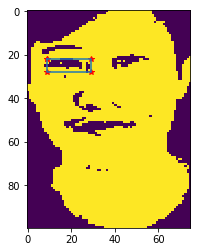

In [24]:
left_eye_position = find_left_eye(image_face_arr, nose_top_position)
left_eye_left_position = left_eye_position[0][0]
left_eye_top_position = left_eye_position[0][1]
left_eye_right_position = left_eye_position[1][0]
left_eye_bottom_position = left_eye_position[1][1]

x = [left_eye_left_position, left_eye_right_position, left_eye_right_position, left_eye_left_position, left_eye_left_position]
y = [left_eye_top_position, left_eye_top_position, left_eye_bottom_position, left_eye_bottom_position, left_eye_top_position]

imshow(image_face_arr)
plot(x, y, 'r*')
plot(x, y)
show()

In [25]:
def find_right_eye(image_face_arr, left_eye_top, left_eye_bottom, left_eye_right):
    right_eye_width = 20
    right_eye_height = 12

    maks = 0
    found = False
    right_eye_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(left_eye_top, left_eye_bottom):
        for idx_col in range(left_eye_right, len(image_face_arr[0])):
            if idx_col + right_eye_width >= image_face_arr.shape[1]: #OOB
                break

            black = sum_region((idx_col, idx_row), (idx_col + right_eye_width, idx_row + right_eye_height // 2), image_face_arr)
            white = sum_region((idx_col, idx_row + right_eye_height // 2), (idx_col + right_eye_width, idx_row + right_eye_height), image_face_arr)
            if black - white >= maks:
                maks = black - white
                right_eye_position[0][0] = idx_col
                right_eye_position[0][1] = idx_row
                right_eye_position[1][0] = idx_col + right_eye_width
                right_eye_position[1][1] = idx_row + right_eye_height // 2
        if idx_row + right_eye_height >= image_face_arr.shape[0]:
            break
    return right_eye_position

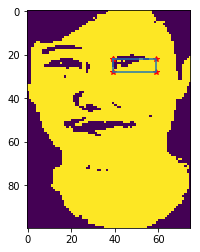

In [26]:
right_eye_position = find_right_eye(image_face_arr, left_eye_top_position, left_eye_bottom_position, left_eye_right_position)
right_eye_left_position = right_eye_position[0][0]
right_eye_top_position = right_eye_position[0][1]
right_eye_right_position = right_eye_position[1][0]
right_eye_bottom_position = right_eye_position[1][1]

x = [right_eye_left_position, right_eye_right_position, right_eye_right_position, right_eye_left_position, right_eye_left_position]
y = [right_eye_top_position, right_eye_top_position, right_eye_bottom_position, right_eye_bottom_position, right_eye_top_position]

imshow(image_face_arr)
plot(x, y, 'r*')
plot(x, y)
show()

In [27]:
def find_left_eyelash(image_face_arr, left_eye_left, left_eye_top, left_eye_right):
    left_eyelash_width = 20
    left_eyelash_height = 5

    maks = 0
    found = False
    left_eyelash_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(left_eye_top - 10, left_eye_top - left_eyelash_height):
        for idx_col in range(left_eye_left - 5, left_eye_right - left_eyelash_width + 5):
            if idx_col + left_eyelash_width >= image_face_arr.shape[1]: #OOB
                break

            white = sum_region((idx_col, idx_row), (idx_col + left_eyelash_width, idx_row + left_eyelash_height // 2), image_face_arr)
            black = sum_region((idx_col, idx_row + left_eyelash_height // 2), (idx_col + left_eyelash_width, idx_row + left_eyelash_height), image_face_arr)
            if black - white >= maks:
                maks = black - white
                left_eyelash_position[0][0] = idx_col
                left_eyelash_position[0][1] = idx_row + left_eyelash_height // 2
                left_eyelash_position[1][0] = idx_col + left_eyelash_width
                left_eyelash_position[1][1] = idx_row + left_eyelash_height
        if idx_row + left_eyelash_height >= image_face_arr.shape[0]:
            break
    return left_eyelash_position

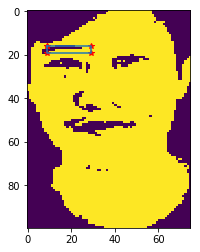

In [28]:
left_eyelash_position = find_left_eyelash(image_face_arr, left_eye_left_position, left_eye_top_position, left_eye_right_position)
left_eyelash_left_position = left_eyelash_position[0][0]
left_eyelash_top_position = left_eyelash_position[0][1]
left_eyelash_right_position = left_eyelash_position[1][0]
left_eyelash_bottom_position = left_eyelash_position[1][1]

x = [left_eyelash_left_position, left_eyelash_right_position, left_eyelash_right_position, left_eyelash_left_position, left_eyelash_left_position]
y = [left_eyelash_top_position, left_eyelash_top_position, left_eyelash_bottom_position, left_eyelash_bottom_position, left_eyelash_top_position]

imshow(image_face_arr)
plot(x, y, 'r*')
plot(x, y)
show()

In [29]:
def find_right_eyelash(image_face_arr, right_eye_left, right_eye_top, right_eye_right):
    right_eyelash_width = 20
    right_eyelash_height = 5

    maks = 0
    found = False
    right_eyelash_position = [[0, 0], [0, 0]] # left top, right bottom
    for idx_row in range(right_eye_top - 10, right_eye_top - right_eyelash_height):
        for idx_col in range(right_eye_left - 5, right_eye_right - right_eyelash_width + 5):
            if idx_col + right_eyelash_width >= image_face_arr.shape[1]: #OOB
                break

            white = sum_region((idx_col, idx_row), (idx_col + right_eyelash_width, idx_row + right_eyelash_height // 2), image_face_arr)
            black = sum_region((idx_col, idx_row + right_eyelash_height // 2), (idx_col + right_eyelash_width, idx_row + right_eyelash_height), image_face_arr)
            if black - white >= maks:
                maks = black - white
                right_eyelash_position[0][0] = idx_col
                right_eyelash_position[0][1] = idx_row + right_eyelash_height // 2
                right_eyelash_position[1][0] = idx_col + right_eyelash_width
                right_eyelash_position[1][1] = idx_row + right_eyelash_height
        if idx_row + right_eyelash_height >= image_face_arr.shape[0]:
            break
    return right_eyelash_position

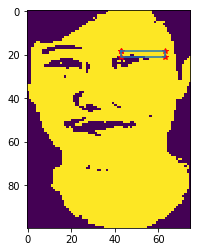

In [30]:
right_eyelash_position = find_right_eyelash(image_face_arr, right_eye_left_position, right_eye_top_position, right_eye_right_position)
right_eyelash_left_position = right_eyelash_position[0][0]
right_eyelash_top_position = right_eyelash_position[0][1]
right_eyelash_right_position = right_eyelash_position[1][0]
right_eyelash_bottom_position = right_eyelash_position[1][1]

x = [right_eyelash_left_position, right_eyelash_right_position, right_eyelash_right_position, right_eyelash_left_position, right_eyelash_left_position]
y = [right_eyelash_top_position, right_eyelash_top_position, right_eyelash_bottom_position, right_eyelash_bottom_position, right_eyelash_top_position]

imshow(image_face_arr)
plot(x, y, 'r*')
plot(x, y)
show()